# Computer Vision

In [33]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchmetrics.classification import MulticlassAccuracy

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [35]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None # don't transform the labels
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None # don't transform the labels
)
class_names = train_data.classes
print(train_data.class_to_idx)
print(f"Image shape: {train_data[0][0].shape}, label: {train_data[0][1]} -> {class_names[train_data[0][1]]}")


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
Image shape: torch.Size([1, 28, 28]), label: 9 -> Ankle boot


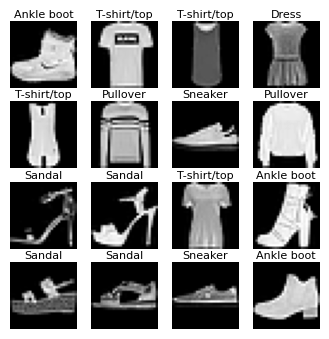

In [36]:
# Plot 16 images with more padding
fig, ax = plt.subplots(4, 4, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        image = train_data[i*4+j][0]
        label = class_names[train_data[i*4+j][1]]
        ax[i][j].imshow(image.squeeze(), cmap='gray')
        ax[i][j].set_title(label, fontsize=8, pad=2.5)
        ax[i][j].axis('off')


In [37]:
# Dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
len(train_dataloader), len(train_dataloader.dataset)

(1875, 60000)

In [38]:
# Model
class FashionMNistModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)
            
model_0 = FashionMNistModelV0(28*28, 128, 10)

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)
accuracy = MulticlassAccuracy(task="multiclass", num_classes=len(class_names))

In [40]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    print(f"Training time on {device}: {end - start:.2f}s")



In [42]:
from tqdm.auto import tqdm

train_time_start_on_cpu = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    train_loss = 0.0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        # calculate loss per batch
        loss = loss_fn(y_pred, y)
        # accumulate loss
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Batch: {batch} Looked at {batch * len(X)}/{len(train_dataloader.dataset)} batches")
    
    train_loss /= len(train_dataloader)
    
    # Testing
    test_loss = 0.0 
    test_acc = 0.0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy(test_pred, y_test)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"Epoch: {epoch+1}/{epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}")
train_time_end_on_cpu = timer()
print_train_time(train_time_start_on_cpu, train_time_end_on_cpu, device='cpu')
    
        

  0%|          | 0/3 [00:00<?, ?it/s]

Batch: 0 Looked at 0/60000 batches
Batch: 400 Looked at 12800/60000 batches
Batch: 800 Looked at 25600/60000 batches
Batch: 1200 Looked at 38400/60000 batches
Batch: 1600 Looked at 51200/60000 batches
Epoch: 1/3, train_loss: 0.3830, test_loss: 0.4333, test_acc: 0.8123
Batch: 0 Looked at 0/60000 batches
Batch: 400 Looked at 12800/60000 batches
Batch: 800 Looked at 25600/60000 batches
Batch: 1200 Looked at 38400/60000 batches
Batch: 1600 Looked at 51200/60000 batches
Epoch: 2/3, train_loss: 0.3416, test_loss: 0.3618, test_acc: 0.8398
Batch: 0 Looked at 0/60000 batches
Batch: 400 Looked at 12800/60000 batches
Batch: 800 Looked at 25600/60000 batches
Batch: 1200 Looked at 38400/60000 batches
Batch: 1600 Looked at 51200/60000 batches
Epoch: 3/3, train_loss: 0.3174, test_loss: 0.3519, test_acc: 0.8441
Training time on cpu: 49.72s
